In [1]:
import pandas as pd
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import numpy as np
from scipy.stats import t
from scipy.stats import f
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from itertools import combinations
from collections import defaultdict

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [137]:
df = pd.read_csv("df_norm_3_time_all_median.csv")

In [138]:
df = df.dropna(subset=['relative_ID'])

# Convert the column to integers
df['relative_ID'] = df['relative_ID'].astype(int)

In [139]:
df["exp_pos_rel_cell"] = (df["experiment_foldername"]
                          + "_"
                          + df["Position_n"].astype(str)
                          + "_"
                          + df["relative_ID"].astype(str))

In [172]:
# exclude all buds that are 'True' in column 'lateral_bud' 
lateral_buds = [
    "exp1_Position_1_5",
    "exp1_Position_2_4",
    "exp1_Position_6_531",
    "exp4_Position_1_5",
    "exp4_Position_4_1131",
    "exp4_Position_4_607",
]

df["lateral_bud"] = np.isin(df["exp_pos_cell"], lateral_buds)
df["lateral_bud"].value_counts()

df["from_lateral_bud"] = np.isin(df["exp_pos_rel_cell"], lateral_buds)
df["lateral_bud"].value_counts()

#df_lat = df[~df['lateral_bud'].isin([True])]
#df_lat

False    9742
True       97
Name: lateral_bud, dtype: int64

In [173]:
df = df[~df['lateral_bud'].isin([True])]

In [174]:
@dataclass
class Cell:
    exp_pos_cell: str
    trajectory: pd.DataFrame

In [175]:
# gets dataframes that contain all frames and data where a particular cell is mother to a daughter cell
def get_mother_trajectory(df, exp_pos_cell):
    df = df[df.exp_pos_cell	== exp_pos_cell] 
    return df[(df.relative_ID > df.Cell_ID) & (df.relationship == 'mother')]

In [176]:
def get_trajectories(exp_pos_cell):

    trajectories = []
    
    trajectory = [exp_pos_cell]

    daughters = get_mother_trajectory(df, exp_pos_cell).exp_pos_rel_cell.unique()

    if len(daughters) == 0: 
        trajectories.append(trajectory)
        return trajectories
        

    for daughter in daughters:
        trajectory = [exp_pos_cell]
        #print(f'Daughter considered is: {daughter}')

        trajectory.append(daughter)
        #print(f'trajectory extended by daughter: {trajectory}')
        
        grand_daughters = get_mother_trajectory(df, daughter).exp_pos_rel_cell.unique()
        
        if len(grand_daughters) == 0:
            trajectories.append(trajectory)
            trajectory = [exp_pos_cell]
            #print(f'No Granddaughters: {trajectory}')
            continue
        
        for grand_daughter in grand_daughters:
            trajectory = [exp_pos_cell, daughter]
            #print(f'next grand daughter: {grand_daughter}')
            trajectory.append(grand_daughter)
            #print(f'trajectory extended by grand daughter: {trajectory}')
            #print(len(trajectory))
            grand_grand_daughters = get_mother_trajectory(df, grand_daughter).exp_pos_rel_cell.unique()

            if len(grand_grand_daughters) == 0:
                trajectories.append(trajectory)
                trajectory = [exp_pos_cell, daughter]
                #print(f'No GrandGranddaughters: {trajectory}')
                continue
            
            for grand_grand_daughter in grand_grand_daughters:
                trajectory = [exp_pos_cell, daughter, grand_daughter]
                #print(f'next grand grand daughter: {grand_grand_daughter}')
                trajectory.append(grand_grand_daughter)
                
                trajectories.append(trajectory)
                
                
                #print(f'trajectory extended grand grand daughter: {trajectory}')#
                #print(len(trajectory))
                
                #trajectory = [exp_pos_cell, daughter, grand_daughter]
                
    return trajectories

In [177]:
signal_to_use = "h"

def get_mother_signals(df, lineage_df, exp_pos_cell):

    signal_dicts = []

    exp_pos_cell_df = df[df.exp_pos_cell == exp_pos_cell]
    initial_mother_signal = exp_pos_cell_df[(exp_pos_cell_df.relative_ID < exp_pos_cell_df.Cell_ID) & (exp_pos_cell_df.relationship == 'mother')][signal_to_use].mean()

    for row in lineage_df.itertuples():
    
        mother = df[df.exp_pos_cell == row.mother]
        daughter = df[df.exp_pos_cell == row.daughter]
        grand_daughter = df[df.exp_pos_cell == row.grand_daughter]
        grand_grand_daughter = df[df.exp_pos_cell == row.grand_grand_daughter]
    
        # the frames where mother connected to daughter
        first_gen = mother[mother.exp_pos_rel_cell == row.daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        mother_signal_first_gen = mother[mother.frame_i.isin(first_gen)][signal_to_use].mean()
    
        # the frames where daughter connected to grand_daughter
        second_gen = daughter[daughter.exp_pos_rel_cell == row.grand_daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        mother_signal_second_gen = mother[mother.frame_i.isin(second_gen)][signal_to_use].mean()
    
        # the frames where grand_daughter connected to grand_grand_daughter
        third_gen = grand_daughter[grand_daughter.exp_pos_rel_cell == row.grand_grand_daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        mother_signal_third_gen = mother[mother.frame_i.isin(third_gen)][signal_to_use].mean()

        # the frames where mother connected to daughter
        first_gen_lin = mother[mother.exp_pos_rel_cell == row.daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        mother_signal = mother[mother.frame_i.isin(first_gen_lin)][signal_to_use].mean()
        # note: mother signal and mother_signal_first_gen is the same thing 
    
        # the frames where daughter connected to grand_daughter
        second_gen_lin = daughter[daughter.exp_pos_rel_cell == row.grand_daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        daughter_signal = daughter[daughter.frame_i.isin(second_gen_lin)][signal_to_use].mean()
    
        # the frames where grand_daughter connected to grand_grand_daughter
        third_gen_lin = grand_daughter[grand_daughter.exp_pos_rel_cell == row.grand_grand_daughter].frame_i.to_list()
        # for those frames get the mean signal of the mother
        grand_daughter_signal = grand_daughter[grand_daughter.frame_i.isin(third_gen_lin)][signal_to_use].mean()
        

        signal_dicts.append({
            "mother_exp_pos_cell": exp_pos_cell,
            "daughter_exp_pos_cell": row.daughter,
            "grand_daughter_exp_pos_cell": row.grand_daughter,
            "grand_grand_daughter_exp_pos_cell": row.grand_grand_daughter,
            "initial_mother_signal": initial_mother_signal,
            "mother_signal_first_gen": mother_signal_first_gen,
            "mother_signal_second_gen": mother_signal_second_gen,
            'mother_signal_third_gen': mother_signal_third_gen,
            "mother_signal": mother_signal,
            "daughter_signal": daughter_signal,
            'grand_daughter_signal': grand_daughter_signal, 
    }
        )

    return signal_dicts

In [178]:
all_signals = []

for cell in df.exp_pos_cell.unique():
    trajectories = get_trajectories(cell)

    new_trajectories = []
    
    for sublist in trajectories:
        while len(sublist) < 4:
            sublist.append(None)
        new_trajectories.append(sublist)

    lineage_df = pd.DataFrame(new_trajectories, columns=['mother', 'daughter', 'grand_daughter', 'grand_grand_daughter'])
    signals = get_mother_signals(df, lineage_df, cell)
    all_signals.extend(signals)

In [179]:
final_df = pd.DataFrame.from_records(all_signals)
final_df['exp_pos'] = final_df['mother_exp_pos_cell'].str.split('_').str[:-1].str.join('_')

In [183]:
final_df['Mother_First_Gen/Daughter'] = final_df['mother_signal_first_gen']/final_df['daughter_signal']
final_df['Daughter/Daughter'] = final_df['daughter_signal']/final_df['daughter_signal']

final_df['Mother_First_Gen/Mother_Sec_Gen'] = final_df['mother_signal_first_gen']/final_df['mother_signal_second_gen']

final_df['Mother_First_Gen/GrandDaughter'] = final_df['mother_signal_first_gen']/final_df['grand_daughter_signal']

final_df['Mother_Sec_Gen/Daughter'] = final_df['mother_signal_second_gen']/final_df['daughter_signal']
final_df['GrandDaughter/Daughter'] = final_df['grand_daughter_signal']/final_df['daughter_signal']

final_df['Mother_First_Gen/Mother_Third_Gen'] = final_df['mother_signal_first_gen']/final_df['mother_signal_third_gen']

In [186]:
# exclude all mothers whose values are outside the heteroplasmic range
# based on the last timepoint distribution with gaussian fitting
# range: 0.47 - 0.65

condition = (final_df['mother_signal'] >= 0.3) & (final_df['mother_signal'] <= 0.7)
final_df_ = final_df[condition]

In [205]:
def calculate_correlation(df, col_x, col_y):
    
    # Group by 'exp_pos' column
    grouped = df.groupby('exp_pos')

    correlation_coefficients = {}
    for group_name, group_df in grouped:
        # Calculate correlation coefficient for the group
        corr_coefficient = group_df[col_x].corr(group_df[col_y])
        correlation_coefficients[group_name] = corr_coefficient

    return correlation_coefficients

In [206]:
# Calculate the correlation coefficients for each combination BUT also per each exp_pos

grouped = final_df.groupby('exp_pos')
correlation_df = pd.DataFrame()
correlation_df['exp_pos'] = grouped.groups.keys()

correlation_df['correlation_m1_d'] = [grouped.get_group(group)['mother_signal_first_gen'].corr(grouped.get_group(group)['daughter_signal']) for group in grouped.groups.keys()]
correlation_df['correlation_m1_gd'] = [grouped.get_group(group)['mother_signal_first_gen'].corr(grouped.get_group(group)['grand_daughter_signal']) for group in grouped.groups.keys()]
correlation_df['correlation_d_gd'] = [grouped.get_group(group)['daughter_signal'].corr(grouped.get_group(group)['grand_daughter_signal']) for group in grouped.groups.keys()]

correlation_df['correlation_m1_m2'] = [grouped.get_group(group)['mother_signal_first_gen'].corr(grouped.get_group(group)['mother_signal_second_gen']) for group in grouped.groups.keys()]
correlation_df['correlation_m1_m3'] = [grouped.get_group(group)['mother_signal_first_gen'].corr(grouped.get_group(group)['mother_signal_third_gen']) for group in grouped.groups.keys()]

correlation_df['correlation_m2_d'] = [grouped.get_group(group)['mother_signal_second_gen'].corr(grouped.get_group(group)['daughter_signal']) for group in grouped.groups.keys()]
correlation_df['correlation_m3_gd'] = [grouped.get_group(group)['mother_signal_third_gen'].corr(grouped.get_group(group)['grand_daughter_signal']) for group in grouped.groups.keys()]

correlation_df['correlation_m1_m2'] = [grouped.get_group(group)['mother_signal_first_gen'].corr(grouped.get_group(group)['mother_signal_second_gen']) for group in grouped.groups.keys()]
correlation_df['correlation_m2_m3'] = [grouped.get_group(group)['mother_signal_second_gen'].corr(grouped.get_group(group)['mother_signal_third_gen']) for group in grouped.groups.keys()]

correlation_df

,exp_pos,correlation_m1_d,correlation_m1_gd,correlation_d_gd,correlation_m1_m2,correlation_m1_m3,correlation_m2_d,correlation_m3_gd,correlation_m2_m3
0,exp1_Position_1,0.593034,0.001465,0.799719,0.785648,0.536834,0.822585,0.573584,0.779477
1,exp1_Position_2,0.821672,0.568949,0.870775,0.888909,0.735226,0.823612,0.536269,0.864378
2,exp4_Position_1,0.946751,0.855080,0.959505,0.921784,0.968245,0.897230,0.854161,0.973607
3,exp4_Position_2,0.658591,0.301957,0.921777,0.838953,0.581331,0.782898,0.473680,0.860676
4,exp4_Position_4,0.703513,0.319741,0.927533,0.772249,0.662460,0.659930,0.375788,0.885403
5,exp4_Position_5,0.794909,0.492613,0.941043,0.932200,0.888595,0.830890,0.652248,0.982281
6,exp5_Position_1,0.574834,0.610675,0.817011,0.795140,0.841981,0.515376,0.478366,0.801160
7,exp5_Position_2,0.711913,0.408063,0.931199,0.908030,0.844549,0.727566,0.529520,0.953751
8,exp5_Position_3,0.770545,0.586152,0.881734,0.866010,0.743557,0.724331,0.478597,0.936203


In [207]:
t_statistic, p_value_m1d_m1m2 = ttest_rel(correlation_df['correlation_m1_d'], correlation_df['correlation_m1_m2'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m1d_m1m2}")

Overall t-test results:
T-statistic: -4.694722848395579
P-value: 0.0015520152320139867


In [208]:
t_statistic, p_value_m1gd_m1m3 = ttest_rel(correlation_df['correlation_m1_gd'], correlation_df['correlation_m1_m3'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m1gd_m1m3}")

Overall t-test results:
T-statistic: -6.204649728967442
P-value: 0.00025811743846584277


In [209]:
t_statistic, p_value_m1d_m1gd = ttest_rel(correlation_df['correlation_m1_d'], correlation_df['correlation_m1_gd'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m1d_m1gd}")

Overall t-test results:
T-statistic: 4.503606930848021
P-value: 0.001992570004524687


In [210]:
t_statistic, p_value_m1m2_m1m3 = ttest_rel(correlation_df['correlation_m1_m2'], correlation_df['correlation_m1_m3'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m1m2_m1m3}")

Overall t-test results:
T-statistic: 2.729100869971629
P-value: 0.0258817652353244


In [211]:
t_statistic, p_value_m2d_m3gd = ttest_rel(correlation_df['correlation_m2_d'], correlation_df['correlation_m3_gd'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m2d_m3gd}")

Overall t-test results:
T-statistic: 6.008010417638683
P-value: 0.0003205204991638172


In [212]:
t_statistic, p_value_m1m2_m2m3 = ttest_rel(correlation_df['correlation_m1_m2'], correlation_df['correlation_m2_m3'])

# Display the results
print("Overall t-test results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value_m1m2_m2m3}")

Overall t-test results:
T-statistic: -2.5944416158109713
P-value: 0.03189214754377137


In [213]:
print(p_value_m1d_m1m2, p_value_m1gd_m1m3, p_value_m1d_m1gd, p_value_m1m2_m1m3, p_value_m2d_m3gd)

0.0015520152320139867 0.00025811743846584277 0.001992570004524687 0.0258817652353244 0.0003205204991638172


In [214]:
melted_corr_df = correlation_df.melt(id_vars='exp_pos', value_vars=['correlation_m1_m2', 'correlation_m1_d', 'correlation_m1_m3', 'correlation_m1_gd', 'correlation_m2_d', 'correlation_m3_gd' , 'correlation_d_gd','correlation_m2_m3' ], 
                               var_name='correlation_type', value_name='correlation')

melted_corr_df.tail(5)

,exp_pos,correlation_type,correlation
67,exp4_Position_4,correlation_m2_m3,0.885403
68,exp4_Position_5,correlation_m2_m3,0.982281
69,exp5_Position_1,correlation_m2_m3,0.801160
70,exp5_Position_2,correlation_m2_m3,0.953751
71,exp5_Position_3,correlation_m2_m3,0.936203


In [216]:
selected_corr= ['correlation_m1_m2', 'correlation_m1_d','correlation_m1_m3','correlation_m1_gd']  # Replace with the correlation types you want to select

selected_corr_df = melted_corr_df[melted_corr_df['correlation_type'].isin(selected_corr)]

No handles with labels found to put in legend.


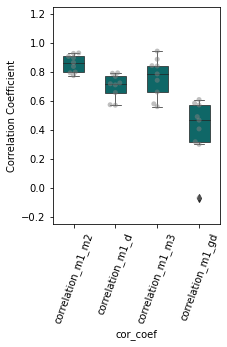

In [169]:
fig, ax = plt.subplots(figsize=(3, 4))

sns.swarmplot(data=selected_corr_df, x='correlation_type', y='correlation', color='gray', alpha=0.5)
sns.boxplot(data=selected_corr_df, x='correlation_type', y='correlation', color= '#007676', linewidth=.7, width=.5)

plt.xlabel('cor_coef')
plt.ylabel('Correlation Coefficient')
#plt.title('Correlation Coefficients btw M-progeny vs M-self')
plt.xticks(rotation=70)
plt.ylim(-0.25, 1.25)
plt.legend().remove()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('cor_coef_m_d_gd_3d_meanProj.svg', transparent = True)

In [220]:
selected_corr_samelev = ['correlation_m2_d', 'correlation_m3_gd']  # Replace with the correlation types you want to select

selected_corr_samelev_df = melted_corr_df[melted_corr_df['correlation_type'].isin(selected_corr_samelev)]

No handles with labels found to put in legend.


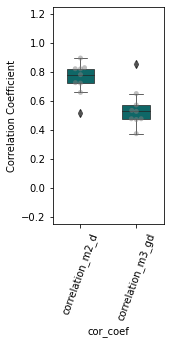

In [221]:
fig, ax = plt.subplots(figsize=(2, 4))

sns.swarmplot(data=selected_corr_samelev_df, x='correlation_type', y='correlation', color='gray', alpha=0.5)

sns.boxplot(data=selected_corr_samelev_df, x='correlation_type', y='correlation', color= '#007676', linewidth=.7, width=.5)

plt.xlabel('cor_coef')
plt.ylabel('Correlation Coefficient')
#plt.title('Correlation Coefficients btw M-progeny vs M-self')
plt.xticks(rotation=70)
plt.ylim(-0.25, 1.25)
plt.legend().remove()
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('cor_coef_m_progeny_same_level_meanProj.svg', transparent = True)